In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.linalg import DenseVector
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.types as typ
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col


import re
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Jonas_rentalPrice-Copy1") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

In [2]:
data_pd = pd.read_json("data/train.json")

# Check the validity of the data

In [3]:
set([t>=0 for t in data_pd["bathrooms"].tolist()])

{True}

In [4]:
set([t>=0 for t in data_pd["bedrooms"].tolist()])

{True}

So as you can see all houses in newyork have at least 0 bathrooms and have at least 0 bedrooms

In [5]:
import time
import datetime
set([0<time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()) for s in data_pd["created"]])

{True}

And all houses in NYC have a posted date

In [6]:
set([len(t.strip())>0 for t in data_pd["description"].tolist()])

{False, True}

In [7]:
set([len(t.strip())>0 for t in data_pd["display_address"].tolist()])

{False, True}

So we can see there are some houses do not have descriptions and there are some houses do not have addresses

In [8]:
set([len(t)>0 for t in data_pd["features"].tolist()])

{False, True}

So there are some features that are empty

In [9]:
set([t>0 for t in data_pd["latitude"].tolist()])

{False, True}

We know NYC is about 40N, 74W, so 0 value on latitude is not possible. Some observation have their latitudes equals to 0, so they need to be imputed

In [10]:
set([t<0 for t in data_pd["longitude"].tolist()])

{False, True}

We know NYC is about 40N, 74W, so 0 value on longitude is not possible. Some observation have their longitudes equals to 0, so they need to be imputed

In [11]:
set([t>0 for t in data_pd["price"].tolist()])

{True}

All houses are not free, which is good

In [12]:
set([len(t)>0 for t in data_pd["street_address"].tolist()])

{False, True}

There are some observations that do not have **street_address**

In [13]:
set([np.isreal(t) for t in data_pd["listing_id"].tolist()])

{True}

In [14]:
len(list(set(data_pd["listing_id"].tolist())))==len(data_pd["listing_id"].tolist())

True

Each **listing_id** is unique, which is expected

In [15]:
set([t for t in data_pd["interest_level"].tolist()])

{'high', 'low', 'medium'}

Each observation must have an **interest_level** in (high, low, medium)

# EDA

In [16]:
interest_level_count = dict()
for j in [t for t in data_pd["interest_level"].tolist()]:
    interest_level_count[j] = interest_level_count.get(j,0) + 1
interest_level_count

{'medium': 11229, 'low': 34284, 'high': 3839}

We have counted the number of medium, low, and high. And as you can see, The data is a little bit imbalanced but not severe. 

## bathrooms and bedrooms

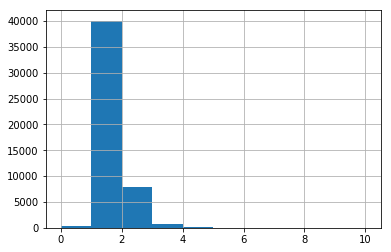

In [17]:
data_pd["bathrooms"].hist()

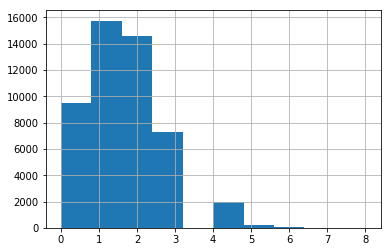

In [18]:
data_pd["bedrooms"].hist()

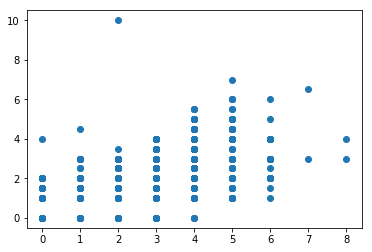

In [19]:
from matplotlib import pyplot as plt
plt.plot(data_pd["bedrooms"], data_pd["bathrooms"], 'o')

From this plot, we can see there is a strange house that has 10 bathrooms but only 2 bedrooms. That is strange, and we may have a check on it

In [20]:
data_pd[data_pd["bathrooms"]==10]["description"].tolist()[0]

'***The building?s well-attended lobby welcomes the residents with its 24-hour doorman and concierge service as well as a fitness center, private storage rooms, bicycle storage, sauna and a laundry area on every floor. Many units have been completely renovated with beautiful new finishes, stone countertops and GE stainless steel appliances. Enjoy the Broadway theater district, Times Square, Central Park and exceptional dining and shopping<br /><br />***HUGE AS BIG AS A FOOT BALL FIELD AND FEATURES HIGH CEILING ,BRAND NEW KITCHEN ,MARBLE BATHROOM, TONS OF CLOSET SPACE ,UNOBSTRUCTED CITY VIEWS AND A TON OF LIGHT DUE TO ITS EXPOSURE AND HIGH FLOOR<br /><br />***TO SET UP TIME AND LOCATION CONTACT RUBENS 039-610-8860<br /><br /><p><a  website_redacted '

In [21]:
data_pd[data_pd["bathrooms"]==10]["photos"].tolist()

[['https://photos.renthop.com/2/6849204_1f92b58ab45a9c2119cf5bae708a3864.jpg',
  'https://photos.renthop.com/2/6849204_1ae5954a51b5345f0d884a3cccd46ba6.jpg',
  'https://photos.renthop.com/2/6849204_0782c1a7feeb02b245be78b737a51b9d.jpg',
  'https://photos.renthop.com/2/6849204_1b7803038b0d3af1499aee849085951f.jpg',
  'https://photos.renthop.com/2/6849204_60bb31a548ed1d570ccfa79a09e4b19e.jpg']]

After checking thses images, I am prettysure that 10 bathrooms is an entry mistake. 

In [22]:
from sklearn.linear_model import LinearRegression
import scipy
scipy.stats.pearsonr(data_pd["bathrooms"], data_pd["bedrooms"])

(0.5334463134173691, 0.0)

The **bathrooms** and **bedrooms** are not highly correlated

So as wee can see most houses in NYC have less than or equal to two bathrooms and have less than 3 bedrooms. 

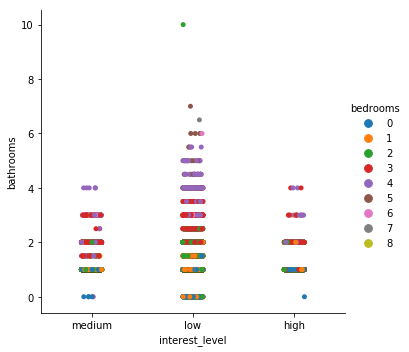

In [23]:
import seaborn
seaborn.catplot(x="interest_level", y="bathrooms", hue = "bedrooms",data = data_pd)

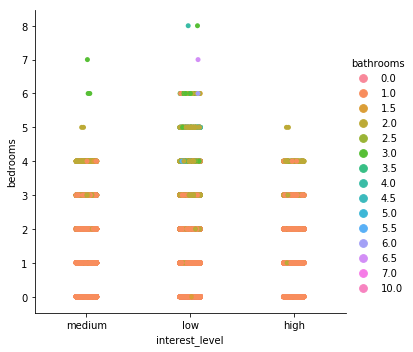

In [24]:
seaborn.catplot(x="interest_level", y="bedrooms", hue = "bathrooms",data = data_pd)

We have observed that if there are more than 5 bathrooms or more than 4 bathrooms in a house, the **interest_level** associated with that house can rarely be high

## price

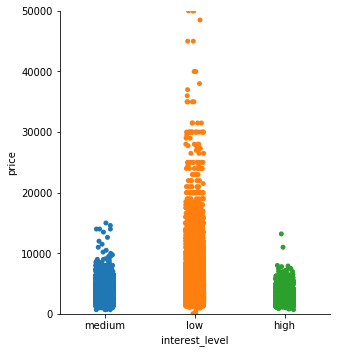

In [25]:
g = seaborn.catplot(x="interest_level", y="price",data = data_pd).set(ylim=(0, 50000))

And we can see the housing rental prices in NYC is very expensive. However, if a house's rental price is more than 10000, the interest level can rarely be high. 

## latitude and longitude

[(38, 44), (-80, -70)]

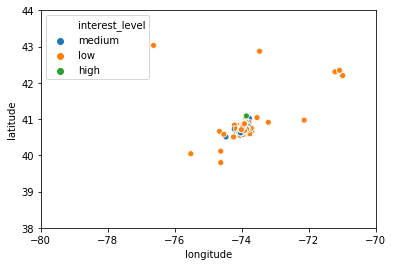

In [26]:
seaborn.scatterplot(x="longitude",
                    y="latitude",
                    hue = "interest_level",
                    data = data_pd).set(ylim=(38, 44),xlim=(-80,-70))

Let's zoom in for a little bit

[(40.4, 41), (-74.25, -73.75)]

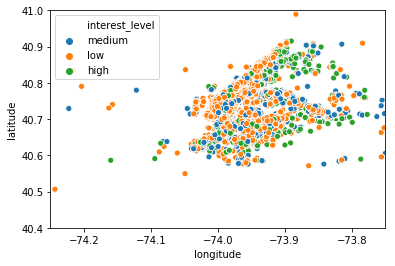

In [27]:
seaborn.scatterplot(x="longitude",
                    y="latitude",
                    hue = "interest_level",
                    data = data_pd).set(ylim=(40.4, 41),xlim=(-74.25,-73.75))

As we can see, the medium, low, and high are have their own clusters each shape as a narrow oval. Therefore, gaussian mixture model may help in this case. 

## created

In [28]:
createdUnixTime = list(map(lambda s:time.mktime(datetime.datetime.strptime(s, 
                                                         "%Y-%m-%d %H:%M:%S").timetuple()), 
         data_pd["created"].tolist()))

(0.0, 3550.0)

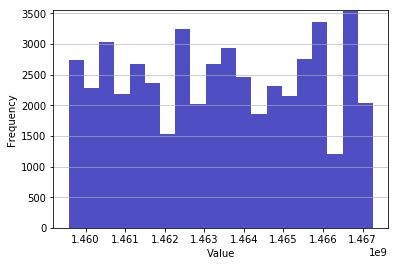

In [29]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=createdUnixTime, 
                            bins=20, 
                            color='#0504aa',
                            alpha=0.7, rwidth=2)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [30]:
data_pd["createdUnixTime"] = createdUnixTime

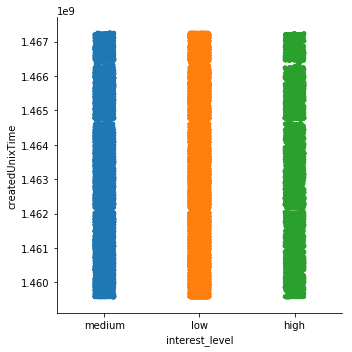

In [31]:
seaborn.catplot(x="interest_level", y="createdUnixTime",data = data_pd)

As you can see the created time for **high** has some gaps that **medium** and **low** does not have, so we may be able to utilize that after some careful feature engineering. 

## features

(0.0, 11150.0)

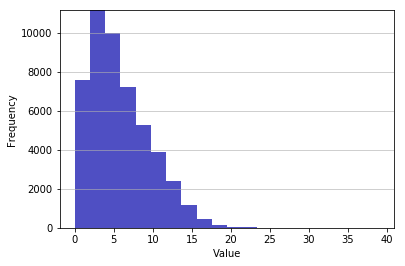

In [32]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=[len(t) for t in data_pd["features"].tolist()], 
                            bins=20, 
                            color='#0504aa',
                            alpha=0.7, rwidth=2)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

And most rows in the **features** column have less than 10 items

In [33]:
data_pd["features_len"] = list(map(len, data_pd["features"].tolist()))

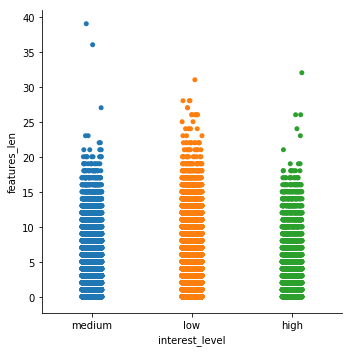

In [34]:
seaborn.catplot(x="interest_level",
                    y="features_len",
                    data = data_pd)

And seems like the length of the **features** does not help...

# Feature Engineering

## created

For both model tesing the prediction, the **created** is converted to the unix time, so that becomes a real number suitable for various of models. 

In [35]:
! cat projectModelRunner.py | grep "mktime"

    input_data_pd["created"] = input_data_pd["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))
    input_data_pd_train["created"] = input_data_pd_train["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))
    input_data_pd_test["created"] = input_data_pd_test["created"].apply(lambda s: time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))


## latitude and longitude

In [36]:
! head -49 Miscellaneous/ModelPipConfig.py | tail -15


        assemblerForGMM = VectorAssembler(inputCols=["out_latitude", "out_longitude"],
                                          outputCol="gmmFeatures")


        gmm = GaussianMixture(featuresCol="gmmFeatures",
                              predictionCol="gmmPrediction",
                              k=7,
                              probabilityCol="gmmAssignmentProbability",
                              tol=0.01,
                              maxIter=100,
                              seed=None)

        gmmLabelOneHotEncoder = OneHotEncoder(inputCol="gmmPrediction", outputCol="gmmPredictionVector")



Because we assume that houses' 2D locations with different interest level are distributed in NYC by different Gaussian mixtures. Points are clustered and one hot encoded and then fitted into the model

## Extreme Value Imputation

I believe that observations with a modified z-score (based on the median absolute deviation) greater than 5.5 are extreme outliers and are entered mistakenly. I wrote the following code for cleaning those outliers. 

In [37]:
! cat FeaturesMakers/OutlierSmoother.py

from pyspark.ml.util import JavaMLReadable, JavaMLWritable
from pyspark.ml.wrapper import JavaEstimator, JavaModel, JavaParams, JavaTransformer, _jvm
from pyspark.ml.common import inherit_doc
from pyspark import since, keyword_only, SparkContext
from pyspark.sql import DataFrame

from pyspark.ml.param.shared import *
from pyspark.ml import Pipeline, Transformer
from typing import Iterable,List
import numpy as np
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.sql.functions import when, lit, col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import FloatType
from Miscellaneous.Logger import Logger

class OutlierSmoother(Transformer):
    def __init__(self, thresh: float, inputCols: List[str]=None, outputCols: List[str]=None):
        if len(inputCols) != len(outputCols):
            raise ValueError("the length of input cols must be equal to the length of output cols")
        super(OutlierSmoother, self).__init__()
  

Basically, the above code will set each of the extreme outliers' values to the average of the remaining data. 

# Model Selection, Parameter Tunning, and Cross Validation

The model selected in this case is Random Forest. Because there are some "cutting points" in the plots, a tree model might help. More trees will increase the robustness of the prediction, and here we use 10 trees. 

Since we have clusterd the **latitude** and **longitude** with GMM, the number of clusters are unknown, so we need to tune that also. 

In [38]:
! head -73 Miscellaneous/ModelPipConfig.py | tail -5

        if self.method == "RandomForest":
            Logger.logger.info("Using the RandomForest")
            rf = RandomForestClassifier(numTrees=10)
            self.paramGrid = ParamGridBuilder().addGrid(gmm.k, [2, 10]).build()
            self.estimator = rf


So we tune the number of clusters from 3 to 10

The cross validation is used to tune the parameters. In this case, we are using the logloss which is defined as follows:

$$
log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),
$$

In [39]:
! cat ModelEvaluators/MultiClassLogLossEvaluator.py

from pyspark.ml.evaluation import Evaluator
import numpy as np
from Miscellaneous.Logger import Logger
class MultiClassLogLossEvaluator(Evaluator):
    def __init__(self, probabilityVectorCol="probability", labelCol="label"):
        self.probabilityVectorCol = probabilityVectorCol
        self.labelCol = labelCol

    @staticmethod
    def computeLogLoss(labels, probVecs):
        if len(labels) != len(probVecs):
            raise ValueError("the length of the labels must be equal to the length of the probVecs")
        if min(labels) < 0 or max(labels) > len(probVecs):
            raise ValueError("Please ensure the labels are 0 based")
        N = len(labels)
        M = len(probVecs[0])
        result = 0.0
        for i in range(N):
            for j in range(M):
                currVec = probVecs[i]
                result = result + (int(labels[i]) == int(j))*np.log(currVec[j])
        return -1*result/(N*1.0)

    def evaluate(self, dataset):
        normalize = lambda vec: vec 

This metric is better when it is smaller. And the above evaluator is passed in the cross validator

In [40]:
! head -58 Miscellaneous/ModelPipConfig.py | tail -1

        self.modelEvaluator = MultiClassLogLossEvaluator(probabilityVectorCol="probability", labelCol="label")


In [41]:
! head -133 projectModelRunner.py | tail -5

    crossval = CrossValidator(estimator=Pipeline(stages=pipelineConfig.getStages()),
                              estimatorParamMaps=pipelineConfig.getParamGrid(),
                              evaluator=pipelineConfig.getModelEvaluator(),
                              numFolds=5)



In [42]:
! tail project.log

2019-02-28 13:03:02,725 INFO 61 outliers in column 'longitude' has been smoothened
2019-02-28 13:03:03,729 INFO 210 outliers in column 'out_price' has been smoothened
2019-02-28 13:03:08,105 INFO Test Error = 0.298738
2019-02-28 13:03:10,345 INFO Log Loss = 0.74259
2019-02-28 13:03:11,482 INFO Here is the confusion matrix with both row and column indices as: high, medium, low
2019-02-28 13:03:11,482 INFO [[  77   11  687]
 [  45   12 2178]
 [  31    7 6857]]
2019-02-28 13:03:11,496 INFO Printing the feature importances
2019-02-28 13:03:11,497 INFO (5,[0,1,2,3,4],[0.055426949408782324,0.08326990122888284,0.012327367623213657,0.7837445809893646,0.06523120074975657])


Here is the confusion matrix based on the default threshold. The last line of this file gives a variable importance measure for each variable used in the random forest stage of the pipeline

In [43]:
! head -56 Miscellaneous/ModelPipConfig.py | tail -8


        assembler = VectorAssembler(inputCols=["out_bathrooms",
                                               "out_bedrooms",
                                               "out_created",
                                               "out_price2",
                                               "gmmPredictionVector"],
                                    outputCol="features")



Here is the order of the variables that we fitted into the random forest classifier. And as you can see, price is the most important variable follows by number of bathrooms and number of bedrooms. The optimal number of the GMM mixtures after the tunning is 2. Time created and GMM clusters are important, even more important than the number of bathrooms. 

# The business goal

The business goal for this project is to predict the interest level of each listing of houses in NYC given their listing information. 
And we have generated estimated probabilities of each listing for different use cases. 

In [44]:
probabilities = list(map(eval,pd.read_csv("predictionOutput.csv")["probability"].tolist()))
np.array(probabilities)

array([[0.0581492 , 0.22273207, 0.71911873],
       [0.04682822, 0.19841723, 0.75475455],
       [0.09096233, 0.26590303, 0.64313464],
       ...,
       [0.03016406, 0.14294173, 0.82689421],
       [0.03016406, 0.14294173, 0.82689421],
       [0.0303191 , 0.14431689, 0.82536401]])

In [45]:
labels = pd.read_csv("predictionOutput.csv")["label"].tolist()

In [46]:
def getPredictionLabel(probabilities, weight):
    #make sure the summation of thresh is 1
    #ALSO make sure the indicies correspond with labels
    output = []
    for currProbVec in probabilities:
        output.append(np.argmax( np.array(currProbVec)*np.array(weight) ))
    return output

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
confusion_matrix(labels,getPredictionLabel(probabilities, [1,1,1]))

array([[  77,   11,  687],
       [  45,   12, 2178],
       [  31,    7, 6857]])

The above confusion matrix is generated by using the default threshold. 
We have obtained 77/(77+45+31) percition and 77/(77+11+687) recall. Which is quite good actually. 

To increase the recall, we can add more weight to the first label

In [49]:
confusion_matrix(labels,getPredictionLabel(probabilities, [4,1,1]))

array([[ 252,    0,  523],
       [ 295,    0, 1940],
       [ 346,    0, 6549]])

Now the recall increased to about 50 percent, and precision is

In [52]:
252/(252+295+346)

0.2821948488241881

Which is still not bad... And actually 28 percent precision is far above the threshold for generating leads for a shortening a sales cycle. 

If we want to increase the precision, we can do:

In [51]:
confusion_matrix(labels,getPredictionLabel(probabilities, [0.5,1,1]))

array([[  12,   59,  704],
       [   5,   42, 2188],
       [   2,   27, 6866]])

## further improvements proposal

1. We have fitted the time variable in the random forest as the unix time. In the random forest setting, that time will be cutted by the mean in between each two observations at each step chosen by the lowest Gini value. However, by this method the time variable is not important in this model. We may fit time as categories such as Months of a year, and that may improve the model performance. 
2. We have not mined the **description** which I think will be important. We may directly use the clustering of the texts and put the method in the pipeline just like the GMM. However, I think a better approach for the **description** would be to first use a model (such as LSTM) to fit a small portion of the data, save that result externally, one-hot encodes that result , and put that into the design matrix of our pipele. 